# Splat Analysis by means Computer Vision

Se va a realizar un estudio y analisis de una splat utilizando tecnicas de Imagen processing y vision por computadora. para ellos se utilizará una gerramienta como python asi como distintas bibliotecas de procesamiento de imagenes como OpenCV y scikit image


## Import packages and parse arguments

Los paquetes que se utilizaran son:

1. `sys`: The sys module provides functions and variables used to manipulate different parts of the Python runtime environment (for example, the list of arguments passed to a command line). https://docs.python.org/3/library/sys.html.
2. `arparse`: The argparse module makes it easy to write user-friendly command-line interfaces. The program defines what arguments it requires, and argparse will figure out how to parse those out of sys.argv. The argparse module also automatically generates help and usage messages and issues errors when users give the program invalid arguments. https://docs.python.org/3/library/argparse.html

In [1]:
# import the necessary packages
import sys, argparse

import cv2
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default="images/650 12H 1  006.png",
	help="path to input image")
ap.add_argument("-c", "--connectivity", type=int, default=8,
	help="connectivity for connected component analysis")
# Before calling parser.parse_args(), all required flag should be False.
sys.argv = ['-f']
args = vars(ap.parse_args())


## Start the procedure

We start reading the image from disk, obtaining its shape (dimensions, i.e, hight (rows), width (cols) and deep (channels))

We display the image with `matplotlib`

(rows,cols,channels)=(768, 1024, 3)


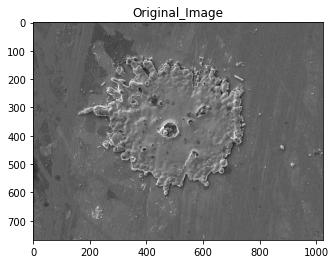

In [2]:
# START:

# Reading
img = cv2.imread(args["image"])
rows,cols,ch = img.shape
print('(rows,cols,channels)={}'.format(img.shape))
plt.title('Original_Image')
plt.imshow(img)
plt.show()

### Resizing

We want resize the image because is very big.

(rows,cols,channels)=(307, 409, 3)


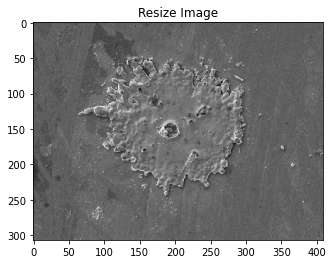

In [3]:
# Resizing
img_res = cv2.resize(
	img,
	(int(cols*0.4), int(rows*0.4)),
	interpolation = cv2.INTER_NEAREST
)
print('(rows,cols,channels)={}'.format(img_res.shape))
plt.title('Resize Image')
plt.imshow(img_res)
plt.savefig('images/Resize_Image.png')
plt.show()

### Contrast enhacement

It can be convenient adjust the contrast to the image in order to obtain better results. Image is converted to RGB because opencv uses BGR. It is necessary por PIL package due to  PIL package is the responsbile to enhace the image contrast with `ImageEnhace.Contrast()` function

Remember PIl uses images, OpenCV and matplotlib use arrays. We must convert adequatly between them.


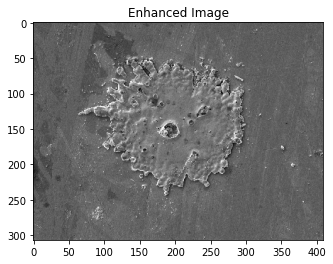

In [4]:
# Adjust Contrast 1%
# Image brightness enhancer
# Notice the COLOR_BGR2RGB which means that the color is
# converted from BGR to RGB
img_con = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_con)
# use a external application in order to show the image
# img_pil.show()

enhancer = ImageEnhance.Contrast(img_pil)

factor = 1.1 #1 gives original image
img_pil_enh = enhancer.enhance(factor)
img_enh = np.asarray(img_pil_enh)

plt.title('Enhanced Image')
plt.imshow(img_enh)
plt.savefig('images/Enhanced_Image.png')
plt.show()

# # or
# img_enh2 = (((img_res - img_res.min()) / (img_res.max() - img_res.min())) **
#            1) * (0.95 - 0.05) + 0.05
#
# plt.title('Enhaced Image 2')
# plt.imshow(img_enh2)
# plt.show()


### Gray convertion and bluring

We convert the image to gray because it is necessary to threshold the image.  It is convenient to blur the image too in order to filter little artifacts previous thresholding.



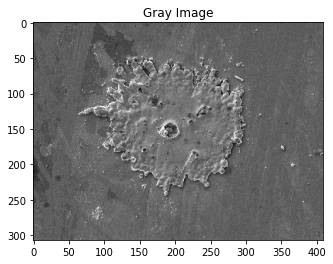

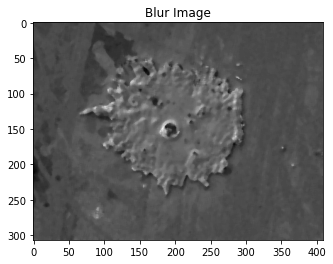

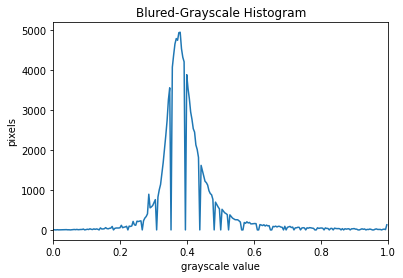

In [5]:
# Colour to gray
#
img_gray = cv2.cvtColor(img_enh, cv2.COLOR_RGB2GRAY)
plt.title('Gray Image')
plt.imshow(img_gray, cmap = 'gray')
plt.savefig('images/Gray Image.png')
plt.show()


img_blur = cv2.medianBlur(img_gray, 5)
plt.title('Blur Image')
plt.imshow(img_blur, cmap = 'gray')
plt.savefig('images/Blur_Image.png')
plt.show()

# create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(img_gray/255.0 , bins=256, range=(0.0, 1.0))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Blured-Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

### Thresholding

An easy guide for simple thresholding with python can be followed in [Image Thresholding in Python – An Easy and Quick Guide](https://www.askpython.com/python/examples/image-thresholding) or in [OpenCV Thresholding ( cv2.threshold)](https://www.pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/). 

For adaptive thresholding in [Adaptive Thresholding with OpenCV (cv2.adaptiveThreshold)](https://www.pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/)

Threshold T=111.0


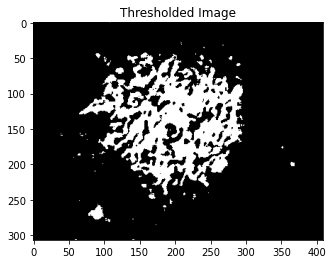

In [6]:
# Thresholding


# apply simple thresholding with a hardcoded threshold value or OTSU thresholding (automatically)

# hardcoded
#(T, img_thr) = cv2.threshold(img_blur, 122, 255, cv2.THRESH_BINARY_INV)
# OTSU
(T, img_thr) = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# apply adaptive thresholding
# cv2.THRESH_BINARY_INV to indicate that any pixel value that passes the threshold test will 
# have an output value of 0. Otherwise, it will have a value of 255

# Adaptive mean
#img_thr = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 2)
# Adaptive gaussian
#img_thr = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 7, 40)

print('Threshold T={}'.format(T))
plt.title('Thresholded Image')
plt.imshow(img_thr, cmap = 'gray')
plt.savefig('images/Thesholding_Image.png')
plt.show()

We can then apply [morphological operations](https://www.pyimagesearch.com/2021/04/28/opencv-morphological-operations/) to clean up the final segmentation.

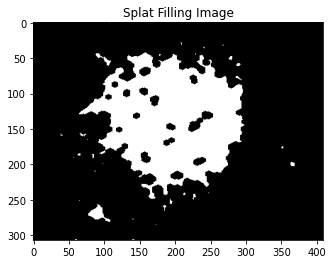

In [7]:
# Morphology

# kernel = np.ones((5,5),np.uint8)

# We manually created a structuring elements with help of Numpy. It is rectangular shape. 
# But in some cases, you may need elliptical/circular shaped kernels. So for this purpose, 
# OpenCV has a function, cv2.getStructuringElement(). You just pass the shape and size of the kernel, 
# you get the desired kernel.

#   Rectangular Kernel  cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
#   Elliptical Kernel   cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#   Cross-shaped Kernel cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))


# erosion = cv2.erode(img,kernel,iterations = 1)
# dilation = cv2.dilate(img,kernel,iterations = 1)
# opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
# closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
# gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
# tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
# blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

img_close = cv2.morphologyEx(img_thr, cv2.MORPH_CLOSE, kernel,iterations = 2)
#img_open = img_open == 0
plt.title('Splat Filling Image')
plt.imshow(img_close, cmap = 'gray')
plt.savefig('images/Splat Filling Image.png')
plt.show()

### Connected Components

The function to use is `output = cv2.connectedComponentsWithStats(img_thr)` where:

1. **Number of labels** is the number of objetcs
2. **Labels** is a matrix with size of the input image where each element has a value equal to its label.
3. **Stats** is a matrix of the stats that the function calculates. It has a length equal to the number of labels and a width equal to the number of stats. It can be used with the OpenCV documentation for it:

    Statistics output for each label, including the background label, see below for available statistics.
        
    Statistics are accessed via stats[label, COLUMN] where available columns are defined below.

    `cv2.CC_STAT_LEFT` The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
    
    `cv2.CC_STAT_TOP` The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
    
    `cv2.CC_STAT_WIDTH` The horizontal size of the bounding box
    
    `cv2.CC_STAT_HEIGHT` The vertical size of the bounding box
    
    `cv2.CC_STAT_AREA` The total area (in pixels) of the connected component
4. **Centroids** is a matrix with the x and y locations of each centroid. The row in this matrix corresponds to the label number.

    

Splat Area = 25678 pixels
Splat Label = 5


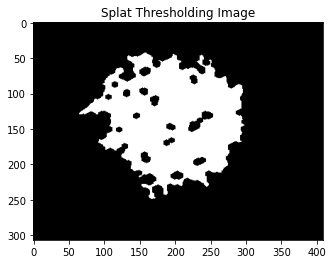

In [8]:
# Connected Components
# Applying cv2.connectedComponents()
# output = cv2.connectedComponentsWithStats(img_thr)

# apply connected component analysis to the thresholded image
output = cv2.connectedComponentsWithStats(img_close, args["connectivity"], cv2.CV_32S)


# Get the results
# The first cell is the number of labels
# The cv2.connectedComponentsWithStats then returns a 4-tuple of:
# 1. numLabels: The total number of unique labels (i.e., number of total
# components) that were detected
num_labels = output[0]
# The second cell is the label matrix
# 2. labels: A mask named labels has the same spatial dimensions as our input
# thresh image. For each location in labels, we have an integer ID value that
# corresponds to the connected component where the pixel belongs. You’ll
# learn how to filter the labels matrix later in this section.
labels = output[1]
# The third cell is the stat matrix
# 3. stats: Statistics on each connected component, including the bounding
# box coordinates and area (in pixels).
stats = output[2]
# The fourth cell is the centroid matrix
# 4. centroids (i.e., center): (x, y)-coordinates of each connected
# component.
centroids = output[3]

#print('Number of labels = {}'.format(output[0]))
#print('Labels = {}'.format(output[1]))
#print('Stats = {}'.format(output[2]))
#print('Centroids = {}'.format(output[3]))

# We only want the label (object) with max area (we discard background or label 0)
splatArea = stats[1:num_labels, cv2.CC_STAT_AREA].max()
print('Splat Area = {} pixels'.format(splatArea))
splatLabel = np.argmax(stats[0:num_labels, 4] == splatArea)
print('Splat Label = {}'.format(splatLabel))

img_thr_splat = (labels == splatLabel).astype("uint8") * 255
plt.title('Splat Thresholding Image')
plt.imshow(img_thr_splat, cmap = 'gray')
plt.savefig('images/Splat Thresholding Image.png')
plt.show()



##################
External Contour
##################
Area External: 27098.0
Perimeter External: 1280.1118204593658
Convexity External: False
Equivalent Diameter External: 185.747799941839
Solidity External: 0.7902941219359261
Aspect Ratio External: 1.1310679611650485
Extent External: 0.5645651902162591
Ellipse Orientation External: 104.42813873291016


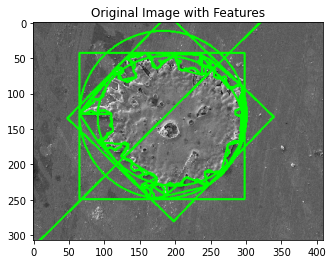

In [9]:
# Extracting Features from splat

# Contours can be explained simply as a curve joining all the continuous points (along the boundary), 
# having same color or intensity. The contours are a useful tool for shape analysis and object detection 
# and recognition.

# For better accuracy, use binary images. So before finding contours, apply threshold or canny edge detection.
# findContours function modifies the source image. So if you want source image even after finding contours, 
# already store it to some other variables.
# In OpenCV, finding contours is like finding white object from black background. 
# So remember, object to be found should be white and background should be black.

contours, hierarchy = cv2.findContours(img_thr_splat, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# RETR_LIST It simply retrieves all the contours, but doesn’t create any
# parent-child relationship. Parents and kids are equal under this rule,
# and they are just contours. ie they all belongs to same hierarchy level.

# RETR_EXTERNAL If you use this flag, it returns only extreme outer flags.
# All child contours are left behind. We can say, under this law, Only the
# eldest in every family is taken care of. It doesn’t care about other
# members of the family :).

# RETR_CCOMP This flag retrieves all the contours and arranges them to a
# 2-level hierarchy. ie external contours of the object (ie its boundary) are
# placed in hierarchy-1. And the contours of holes inside object (if any) is
# placed in hierarchy-2. If any object inside it, its contour is placed again
# in hierarchy-1 only. And its hole in hierarchy-2 and so on.

# RETR_TREE And this is the final guy, Mr.Perfect. It retrieves all the
# contours and creates a full family hierarchy list. It even tells, who is
# the grandpa, father, son, grandson and even beyond... :).

#print(contours)
#print(hierarchy)

green = (0,255,0)
red = (255,0,0)
M = []    # List Moments
A = []    # List Areas
P = []    # List Perimeters
K = []    # List Convexity
AR = []   # List Aspect Ratio
E = []    # List Extent
S = []    # List Solidity
ED = []   # List Equivalent Diameter
O = []    # List Ellipse Orientation

# All objects in the scene
#for i in range(len(contours)):
# Only the external object
for i in range(1):
	if i == 0:
		color = green
		cont = "External"
	else:
		color = red
		cont = "Internal"
	cnt = contours[i]
	Mo = cv2.moments(cnt)
	M.append(Mo)
	# print(len(contours))
	print("\n##################")
	print("{} Contour".format(cont))
	print("##################")

	##############
	#  FEATURES  #
	##############

	# Centroid
	cx = int(M[i]['m10']/M[i]['m00'])
	cy = int(M[i]['m01']/M[i]['m00'])

	# Area
	area = cv2.contourArea(cnt)
	A.append(area)
	print("Area {}: {}".format(cont, A[i]))

	# Perimeters
	perimeter = cv2.arcLength(cnt, True)
	P.append(perimeter)
	print("Perimeter {}: {}".format(cont, P[i]))

	# Convexity
	k = cv2.isContourConvex(cnt)
	K.append(k)
	print("Convexity {}: {}".format(cont, K[i]))

	# Equivalent Diameter
	equi_diameter = np.sqrt(4*area/np.pi)
	ED.append(equi_diameter)
	print("Equivalent Diameter {}: {}".format(cont, ED[i]))

	# Draw Contours
	cv2.drawContours(img_res, [cnt], 0, color, 2)
	#cv2.drawContours(img_res, [contours[i]], 0, color, 2)
    
	# Draw Approx Polygone (if epsilon = 0 draw a perfect contour)
	epsilon = 0.009*cv2.arcLength(cnt, True)
	approx = cv2.approxPolyDP(cnt, epsilon, True)
	cv2.drawContours(img_res, [approx], 0, color, 2)  

	# Draw Convex Hull calculate Solidity
	# In geometry, the convex hull or convex envelope or convex closure of a
	# shape is the smallest convex set that contains it.
	hull = cv2.convexHull(cnt)
	cv2.drawContours(img_res, [hull], 0, color, 2)
		# Solidity
	hull_area = cv2.contourArea(hull)
	solidity = float(area) / hull_area
	S.append(solidity)
	print("Solidity {}: {}".format(cont, S[i]))

	# Axis-aligned Bounding Rectangle calculate Aspect ratio
	# Bounding Box
	# In geometry,the minimum or smallest bounding or enclosing box for a point
	# set (S) in N dimensions is the box with the smallest measure (area,
	# volume,or hypervolume in higher dimensions) within which all the points
	# lie.
	x, y, w, h = cv2.boundingRect(cnt)
	cv2.rectangle(img_res, (x, y), (x+w, y+h), color, 2)
		# Aspect Ratio
	aspect_ratio = float(w) / h
	AR.append(aspect_ratio)
	print("Aspect Ratio {}: {}".format(cont, AR[i]))
		# Extent
	rect_area = w * h
	extent = float(area) / rect_area
	E.append(extent)
	print("Extent {}: {}".format(cont, E[i]))

	# Arbitrarily oriented Bounding Rectangle (minArea)
	rect = cv2.minAreaRect(cnt)
	box = cv2.boxPoints(rect)
	box = np.int0(box)
	cv2.drawContours(img_res, [box], 0, color, 2)

	# Minimum Enclosing Circle
	(x,y),radius = cv2.minEnclosingCircle(cnt)
	center = (int(x),int(y))
	radius = int(radius)
	cv2.circle(img_res, center, radius, color, 2)
    
	# Fitting an Ellipse
	ellipse = cv2.fitEllipse(cnt)
	cv2.ellipse(img_res, ellipse, color, 2)
	O.append(ellipse[2])
	print("Ellipse Orientation {}: {}".format(cont, ellipse[2]))
    
	# Fitting a Line (this can give us a preferent direction)
	rows,cols = img_res.shape[:2]
	[vx, vy, x, y] = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)
	lefty = int((-x*vy/vx)+y)
	righty = int(((cols-x)*vy/vx)+y)
	cv2.line(img_res, (cols-1,righty), (0, lefty), color, 2)
    
	# Mask and Pixel Points
	mask = np.zeros(img_gray.shape,np.uint8)
	cv2.drawContours(mask,[cnt],0,255,-1)
	pixelpoints = np.transpose(np.nonzero(mask))
	#pixelpoints = cv2.findNonZero(mask)

	# Maximum Value, Minimum Value and their locations
	min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img_gray, mask = mask)

	# Mean Color or Mean Intensity
	mean_val = cv2.mean(img_res, mask = mask)

	# Extreme Points
	leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
	rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
	topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
	bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

plt.title('Original Image with Features')   
plt.imshow(img_res)
plt.savefig('images/Original Image with Features.png')
plt.show()

(rows,cols,channels)=(768, 1024, 3)


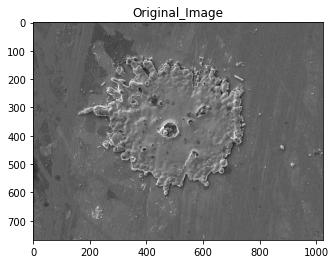

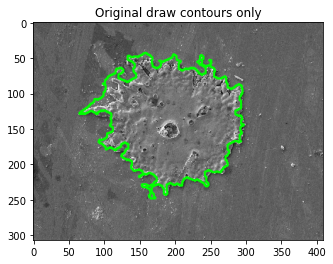

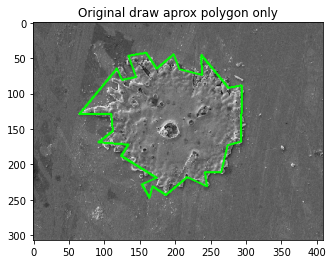

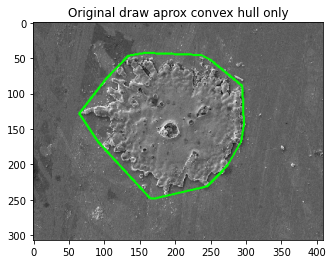

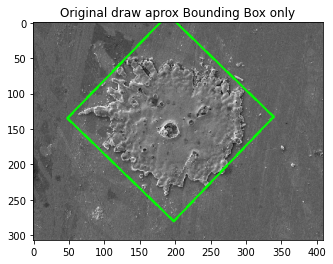

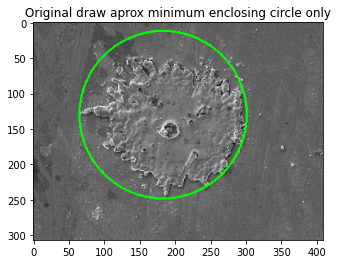

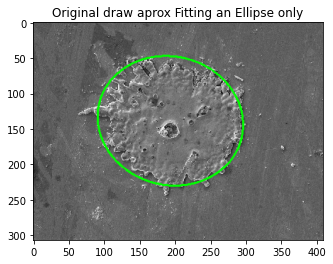

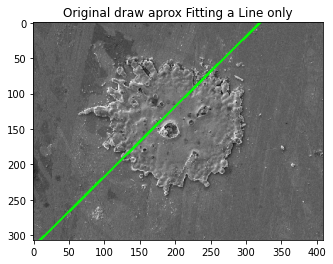

In [10]:
# image with external contour
img = cv2.imread(args["image"])
rows,cols,ch = img.shape
print('(rows,cols,channels)={}'.format(img.shape))
plt.title('Original_Image')
plt.imshow(img)
plt.show()

img_res = cv2.resize(
	img,
	(int(cols*0.4), int(rows*0.4)),
	interpolation = cv2.INTER_NEAREST
)

img_contour = np.copy(img_res)
cv2.drawContours(img_contour, [cnt], 0, color, 2)
plt.title('Original draw contours only')   
plt.imshow(img_contour)
plt.savefig('images/Original with draw contours only.png')
plt.show()

# Draw Approx Polygone (if epsilon = 0 draw a perfect contour)
# if you change the value for epsilon parameter you can change the aspect of polygon.
img_polygon = np.copy(img_res)
epsilon = 0.009*cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)
cv2.drawContours(img_polygon, [approx], 0, color, 2)
plt.title('Original draw aprox polygon only')   
plt.imshow(img_polygon)
plt.savefig('images/Original with draw polygon.png')
plt.show()

# Draw Convex Hull calculate Solidity
# In geometry, the convex hull or convex envelope or convex closure of a
# shape is the smallest convex set that contains it.
img_conhull = np.copy(img_res)
hull = cv2.convexHull(cnt)
cv2.drawContours(img_conhull, [hull], 0, color, 2)
plt.title('Original draw aprox convex hull only')   
plt.imshow(img_conhull)
plt.savefig('images/Original with convex hull.png')
plt.show()

# Arbitrarily oriented Bounding Rectangle (minArea)
img_bbox = np.copy(img_res)
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img_bbox, [box], 0, color, 2)
plt.title('Original draw aprox Bounding Box only')   
plt.imshow(img_bbox)
plt.savefig('images/Original Bounding Box.png')
plt.show()

# Minimum Enclosing Circle
img_mec = np.copy(img_res)
(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)
cv2.circle(img_mec, center, radius, color, 2)
plt.title('Original draw aprox minimum enclosing circle only')   
plt.imshow(img_mec)
plt.savefig('images/Original minimum enclosing circle.png')
plt.show()

# Fitting an Ellipse
img_fel = np.copy(img_res)
ellipse = cv2.fitEllipse(cnt)
cv2.ellipse(img_fel, ellipse, color, 2)
plt.title('Original draw aprox Fitting an Ellipse only')   
plt.imshow(img_fel)
plt.savefig('images/Original Fitting an Ellipse.png')
plt.show()

# Fitting a Line (this can give us a preferent direction)
img_fal = np.copy(img_res)
rows,cols = img_fal.shape[:2]
[vx, vy, x, y] = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)
lefty = int((-x*vy/vx)+y)
righty = int(((cols-x)*vy/vx)+y)
cv2.line(img_fal, (cols-1,righty), (0, lefty), color, 2)
plt.title('Original draw aprox Fitting a Line only')   
plt.imshow(img_fal)
plt.savefig('images/Original Fitting a Line.png')
plt.show()